In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Inferring biased-persistent parameters from observation

If one assumes a biased-persistent random walk is the underlying mechanism driving the motion of leukocytes, the next question becomes: given a set of observations of cells moving in the vicinity of a wound, what parameters values are likely to have generated this data? The formal answer can be stated using Bayes rule.

<br>

$$
p(\phi|\mathcal{D}) = \frac{p(\mathcal{D}|\phi)p(\phi)}{p(\mathcal{D})} 
\label{eq:bayes1}
$$

<br>

In the numerator, $p(\mathcal{D}|\phi)$ is the probability of observing the data $\mathcal{D}$ given a specific set of parameters $\phi$ and $p(\phi)$ represents the user's prior beliefs about the distribution over parameters. In the denominator, $p(\mathcal{D})$ is the probability of observing the data independent of any set of parameters, which in principle can be found by integrating the numerator over all values of $\phi$.

<br>

T trajectory data $\mathcal{D}$ is split into a set of $N$ distinct trajectories $\pi^{i}$. Since all paths are assumed to be independent of one another, the probability of separately observing all of these paths given a set of parameters will then be the product of the probability of observing each one individually.  

<br>

$$
p(\mathcal{D}|\phi) = \prod_{i=1}^{N} p(\pi^{i}|\phi). 
\label{eq:p_1}
$$

<br>

From each path $\pi^{i}$, which contains $T$ $x$-$y$ coordinate readings, one can extract $T-1$ angle observations, $\alpha^{i}_{t}$. Correspondingly, there are associated $T-1$ angles towards the source, $\beta^{i}_{t}$ for each step of the trajectory. Finally, there are $T-2$ \emph{previous} angles observations $\alpha^{i}_{t-1}$. If one makes the assumption that at the first step the cell must observe biased motion (since there is no previous angle for persistent motion to apply to) then the probability of observing a single path $\pi^{i}$ is

<br>

$$
p(\pi^{i}|\phi) = p_{\phi}(\alpha^{i}_{\, 1}|\beta^{i}_{\, 1}) \prod_{t=2}^{T-1} p_{\phi}(\alpha^{i}_{\,t}|\beta_{\, t}^{i}, \alpha_{\, t-1}^{i}), 
$$

<br>

where these distribution values are obtained from the wrapped normal distribution. Putting this together gives 

<br>

$$
p(\mathcal{D}|\phi)p(\phi) = L(\phi) = p(\phi) \prod_{i=1}^{N} p_{\phi}(\alpha^{i}_{\, 1}|\beta^{i}_{\, 1}) \prod_{t=2}^{T-1} p_{\phi}(\alpha^{i}_{\,t}|\beta_{\, t}^{i}, \alpha_{\, t-1}^{i}).
\label{eq:p_2}
$$

<br>

However, in order to avoid floating point errors, it is more convenient to work with the log likelihood. 

<br>

$$
\log L(\phi) = \log p(\phi) + \sum_{i=1}^{N} \log p_{\phi}(\alpha^{i}_{\, 1}|\beta^{i}_{\, 1}) + \sum_{i=1}^{N}  \sum_{t=2}^{T-1} \log p_{\phi}(\alpha^{i}_{\,t}|\beta_{\, t}^{i}, \alpha_{\, t-1}^{i}).
\label{eq:logp_2}
$$

<br>

We can then use this to sequentially update parameters using the Metropolis Hastings algorithm. 

$$
a = \frac{L(\phi')}{L(\phi_t)} = \exp \big( \log L(\phi') - \log L(\phi_t) \big), 
$$




In [1]:
# allow imports from the LM package
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=6, linewidth=5000, threshold=5000, suppress=True)

In [4]:
# Run this cell twice!!
%matplotlib notebook

In [5]:
from in_silico.walkers import BP_Leukocyte
from in_silico.sources import PointSource

<IPython.core.display.Javascript object>


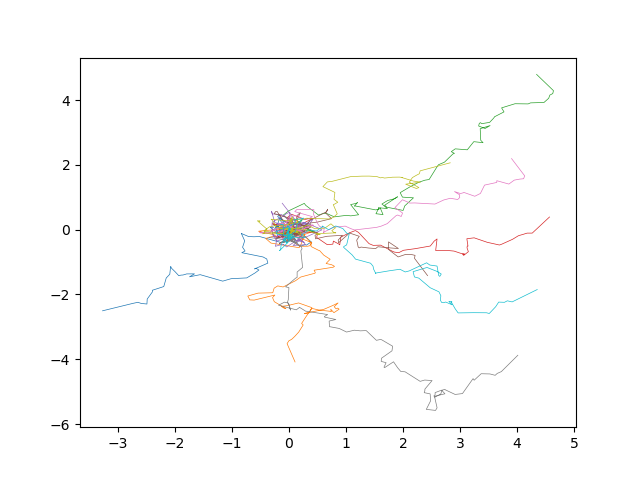

In [6]:
# parametrise some leukocytes
w, p, b = 0.5, 0.6, 0.7
source = PointSource(position=np.array([0, 0]))
walker = BP_Leukocyte(params=np.array([w, p, b]), source=source)

# simulate some paths
n_leukocytes = 10
X0s = np.random.uniform(-5, 5, (n_leukocytes, 2))
paths = walker.walk(X0s, T=100)

# plot the trajectories
plt.figure()
for i in range(n_leukocytes):
    plt.plot(paths[:, 0, i], paths[:, 1, i], linewidth=0.5, alpha=1)

In [7]:
from inference.walker_inference import BiasedPersistentInferer
from utils.plotting import plot_wpb_dist

Beginning MCMC walk in parallel


Total acceptance Rate: 0.724. Rolling acceptance rate: 0.700:  97%|█████████▋| 12598/13000 [00:06<00:00, 1913.09it/s]
Total acceptance Rate: 0.766. Rolling acceptance rate: 0.810: 100%|██████████| 13000/13000 [00:06<00:00, 1888.35it/s]
Total acceptance Rate: 0.767. Rolling acceptance rate: 0.810: 100%|██████████| 13000/13000 [00:06<00:00, 1873.41it/s]
Total acceptance Rate: 0.756. Rolling acceptance rate: 0.720: 100%|██████████| 13000/13000 [00:06<00:00, 1865.34it/s]
Total acceptance Rate: 0.727. Rolling acceptance rate: 0.830: 100%|██████████| 13000/13000 [00:06<00:00, 1861.53it/s]


Completed MCMC walk in 7.11s


<IPython.core.display.Javascript object>


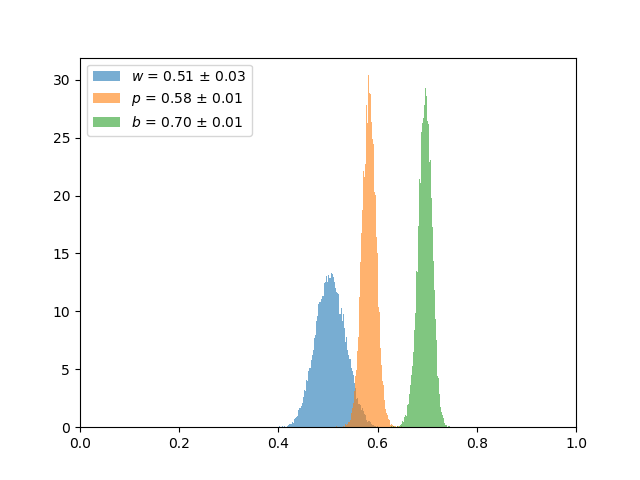

In [8]:
# instantiate an inferer
inferer = BiasedPersistentInferer(paths, source)
dist_out = inferer.multi_infer(n_walkers=5,
                               n_steps=10000,
                               burn_in=3000, 
                               suppress_warnings=True)

# plot the distribution
plot_wpb_dist(dist_out)

## Take a look at the mixing

<IPython.core.display.Javascript object>


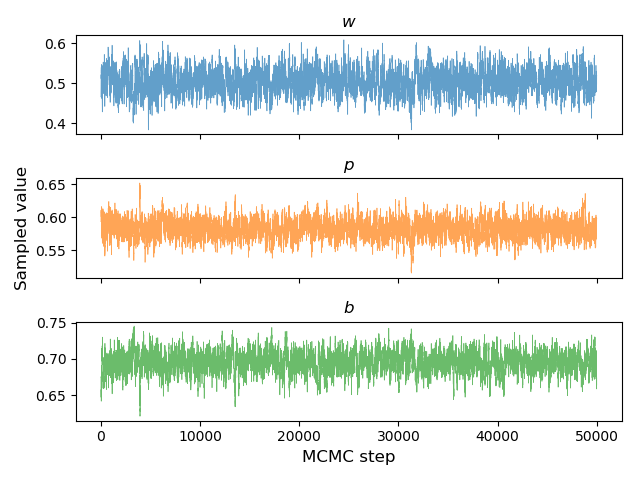

In [9]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True)

for i in range(3):
    axes[i].plot(dist_out[:, i], linewidth=0.5, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], alpha=0.7)
    axes[i].set_title(['$w$', '$p$', '$b$'][i])
    
axes[1].set_ylabel('Sampled value', size='large')
axes[2].set_xlabel('MCMC step', size='large')
plt.tight_layout()